In [4]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Import MNIST data set with sklearn
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [5]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

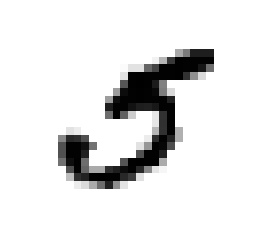

In [8]:
# Grab one instance vector and reshape to form a 28x28 pixel picture
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
y[36000] # Image displays a 5

5.0

In [10]:
# MNIST data set is already split into training set and testing set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# Shuffle the data set
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [13]:
type(X_train)

numpy.ndarray

In [14]:
# Let's create a binary classifier
# Only job is to determine if a number is a 5, or is not a 5
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [15]:
type(y_train_5)

numpy.ndarray

In [16]:
y_train_5

array([False, False, False, ..., False, False, False], dtype=bool)

In [17]:
y_test_5

array([False, False, False, ..., False, False, False], dtype=bool)

In [18]:
# Train a stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

C:\Users\Gabe Villasana\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [23]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [27]:
# Measure accuracy with cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.95725,  0.96005,  0.956  ])

In [30]:
'''
While over 95% accuracy may seem amazing, it turns out that a classifier that always predicts not 5 has 90% accuracy.
In fact, accuracy is generally not the preferred performance measure for classifiers. A better way to measure classifiers
is with a confusion matrix
'''

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

'''
Each row in the confusion matrix represents an actual class, while each column represents a predicted class. 
The first row of the matrix considers non-5 images: 53,343 were predicted correctly as non-5s, and 1236 were
incorrectly predicted to be 5s. Similarly, the second row of the matrix considers 5s. 1298 were wrongly
classified as non-5's, while 4123 were correctly classified as 5s. A perfect classifier would only have non-zero
values in its main diagonal.
'''
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53343,  1236],
       [ 1298,  4123]], dtype=int64)

In [31]:
# Can also use precision and recall as performance metrics
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # When classifier claims a 5, correct only 77% of the time

0.76935995521552525

In [32]:
recall_score(y_train_5, y_train_pred) # Classifier only detects 76% of the 5s

0.76056078214351597

In [34]:
# Can combine precision and recall into 1 metric called the F_1 score
# F_1 score is the harmonic mean of recall and precision
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.76493506493506502

In [35]:
# Precision and recall are indirectly correlated (precision/recall tradeoff)
# Let's take a look at the threshold for the SGD classifier
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 97370.06164761])

In [37]:
threshold = 0 # SGD classifier's default threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [38]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # Thus, raising threshold decreases recall

array([False], dtype=bool)

In [41]:
# Let's figure out which threshold we want to use to optimize our classifier
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = "decision_function")

In [43]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [44]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

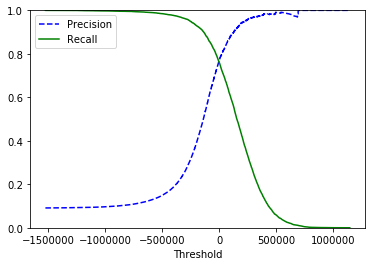

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [56]:
# For the sake of experimentation, suppose we need 90% precision. Based on the above graph, this means we
# need a threshold of roughly 130,000

y_train_pred_90 = (y_scores > 130000)
precision_score(y_train_5, y_train_pred_90)

0.90271903323262837

In [57]:
recall_score(y_train_5, y_train_pred_90)

0.55118981737686779

In [58]:
# Thus to increment precision, can just increment threshold (at the expense of recall)
# Let's graph the receiver operating characteristic curve
from sklearn.metrics import roc_curve

# False positive rate, true positive rate
# TPR is synonymous with recall
# FPR is ratio of negative instances that are incorrectly classified as positive
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

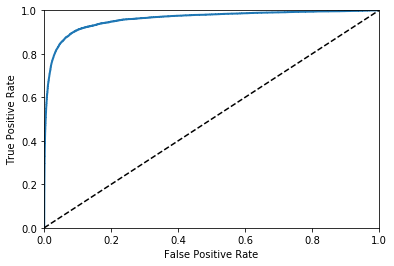

In [59]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [60]:
'''
The dotted line represents the ROC curve of a truly random classifier. One way to compare classifiers is to measure
the AUC (area under the curve). A perfect classifier will have AUC = 1
'''
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96011025807211936

In [61]:
# Now lets train a Random Forest Classifier and compare it to the SGD classifier
# Note, RandomForestClassifier does not have a decision_function() method. Instead it has a predict_proba() method
# This method returns an array where each row is an instance and each column is a class. Then, the value at some
# index is the probability that instance is equal to the class
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [62]:
# To plot an ROC curve, you need scores, not probabilities. Thus, use the positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

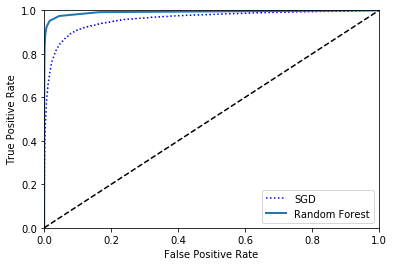

In [64]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [65]:
# Check AUC score
roc_auc_score(y_train_5, y_scores_forest)

0.99185282211127801

In [67]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest) # 98% precision

0.98301023742104121

In [68]:
recall_score(y_train_5, y_train_pred_forest) # 83% recall

0.83250322818668143

In [69]:
# Let's expand to the multi-class case
# Scikit learn recognizes when we want to train multiple binary classifiers for a one verse all learning scheme
# Under the hood, scikit learn actually trained 10 binary classifiers
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([ 5.])

In [70]:
# Make sure have 10 scores
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  19492.23549475, -416025.59848003, -521670.42440078,
        -145964.99472167, -445069.49659196,   97370.06164761,
        -742280.213011  , -498806.79199321, -815776.73899703,
        -687822.19893844]])

In [71]:
np.argmax(some_digit_scores) # Highest score is for class 5

5

In [72]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [74]:
sgd_clf.classes_[5]

5.0

In [75]:
# Assuming you want to force Scikit learn to use a OneVsOneClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\Gabe Villasana\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 5.])

In [76]:
len(ovo_clf.estimators_)

45

In [77]:
# Training a RandomForestClassifier is just as easy
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [78]:
forest_clf.predict_proba([some_digit]) # Highest probability is at class 5

array([[ 0.2,  0. ,  0. ,  0. ,  0. ,  0.7,  0. ,  0. ,  0. ,  0.1]])

In [79]:
# Evaluate SGD classifier with cross validation score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.8554789 ,  0.85959298,  0.87563134])

In [80]:
# Try scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91046791,  0.90829541,  0.91113667])

In [81]:
# Error Analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    2,   22,   11,    9,   51,   43,    9,   39,    3],
       [   1, 6469,   44,   27,    6,   38,    8,   11,  128,   10],
       [  54,   39, 5344,  104,   77,   24,  100,   49,  153,   14],
       [  52,   39,  138, 5357,    3,  233,   35,   55,  131,   88],
       [  21,   29,   37,   12, 5377,    8,   58,   31,   86,  183],
       [  73,   45,   35,  182,   77, 4614,  115,   32,  171,   77],
       [  35,   26,   45,    2,   45,   94, 5618,    6,   47,    0],
       [  24,   21,   71,   34,   59,   11,    6, 5824,   18,  197],
       [  56,  157,   81,  171,   15,  165,   54,   25, 5006,  121],
       [  45,   35,   28,   89,  163,   39,    2,  212,   81, 5255]], dtype=int64)

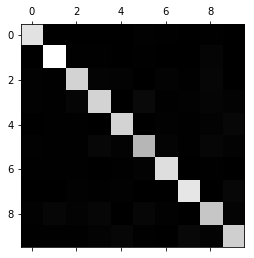

In [82]:
plt.matshow(conf_mx, cmap=plt.cm.gray) # Show matrix as colored grid
plt.show()

In [83]:
'''
In confusion matrix, most colored images are on main diagonal, which means most instances were classified correctly
'''

# Let's put everything in terms of ratios
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

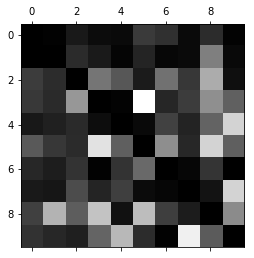

In [84]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [85]:
# For fun, let's attempt a multilabel classification
# First index will determine if the number is greater than 7
# The second index will tell us if it is an odd number
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [88]:
knn_clf.predict([some_digit]) # 5 is smaller than 7 and odd. should output [false, true]

array([[False,  True]], dtype=bool)

In [87]:
# Computer average F_1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro") # Assumes all labels are equally important

KeyboardInterrupt: 